In [2]:
# imports 
import math
import numpy as np 
import pandas as pd 
import plotly.express as ex
import plotly.graph_objects as go
import plotly.offline as pyo
from datetime import datetime
# helpful modules
import fuzzywuzzy
from fuzzywuzzy import process
import chardet

pyo.init_notebook_mode()

C:\Users\lianq\miniconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



# 1. load data

In [3]:
# load data
vacc_df = pd.read_csv("COVID-19 World Vaccination Progress/country_vaccinations.csv")
summary_df = pd.read_csv("Covid-19 Global Dataset/worldometer_coronavirus_summary_data.csv")
daily_df = pd.read_csv("Covid-19 Global Dataset/worldometer_coronavirus_daily_data.csv")
vacc_manu = pd.read_csv("COVID-19 World Vaccination Progress/country_vaccinations_by_manufacturer.csv")

In [4]:
vacc_df.shape

(73009, 15)

In [5]:
vacc_df.tail()

country iso_code        date  total_vaccinations  people_vaccinated  \
73004  Zimbabwe      ZWE  2022-01-21           7496882.0          4234640.0   
73005  Zimbabwe      ZWE  2022-01-22           7506786.0          4239537.0   
73006  Zimbabwe      ZWE  2022-01-23           7512903.0          4242647.0   
73007  Zimbabwe      ZWE  2022-01-24           7517985.0          4245063.0   
73008  Zimbabwe      ZWE  2022-01-25           7525574.0          4248576.0   

       people_fully_vaccinated  daily_vaccinations_raw  daily_vaccinations  \
73004                3262242.0                 13650.0             10405.0   
73005                3267249.0                  9904.0             10567.0   
73006                3270256.0                  6117.0             10631.0   
73007                3272922.0                  5082.0             10273.0   
73008                3276998.0                  7589.0              9579.0   

       total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
73004                           49.67                          28.06   
73005                           49.74                          28.09   
73006                           49.78                          28.11   
73007                           49.81                          28.13   
73008                           49.86                          28.15   

       people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
73004                                21.62                           689.0   
73005                                21.65                           700.0   
73006                                21.67                           704.0   
73007                                21.69                           681.0   
73008                                21.71                           635.0   

                                                vaccines         source_name  \
73004  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73005  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73006  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73007  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73008  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   

                                          source_website  
73004  https://www.arcgis.com/home/webmap/viewer.html...  
73005  https://www.arcgis.com/home/webmap/viewer.html...  
73006  https://www.arcgis.com/home/webmap/viewer.html...  
73007  https://www.arcgis.com/home/webmap/viewer.html...  
73008  https://www.arcgis.com/home/webmap/viewer.html...

In [6]:
summary_df.head()

country continent  total_confirmed  total_deaths  total_recovered  \
0  Afghanistan      Asia           158275        7367.0         145750.0   
1      Albania    Europe           213257        3228.0         202077.0   
2      Algeria    Africa           220415        6310.0         151347.0   
3      Andorra    Europe            25289         141.0          21511.0   
4       Angola    Africa            86636        1789.0          67477.0   

   active_cases  serious_or_critical  total_cases_per_1m_population  \
0        5158.0               1124.0                           3932   
1        7952.0                 23.0                          74227   
2       62758.0                 34.0                           4893   
3        3637.0                 31.0                         326512   
4       17370.0                  7.0                           2518   

   total_deaths_per_1m_population  total_tests  total_tests_per_1m_population  \
0                           183.0     826810.0                        20541.0   
1                          1124.0    1495002.0                       520354.0   
2                           140.0     230861.0                         5125.0   
3                          1820.0     249838.0                      3225714.0   
4                            52.0    1296669.0                        37686.0   

   population  
0    40250878  
1     2873049  
2    45046063  
3       77452  
4    34407243

In [7]:
daily_df.head()

date      country  cumulative_total_cases  daily_new_cases  \
0  2020-2-15  Afghanistan                     0.0              NaN   
1  2020-2-16  Afghanistan                     0.0              NaN   
2  2020-2-17  Afghanistan                     0.0              NaN   
3  2020-2-18  Afghanistan                     0.0              NaN   
4  2020-2-19  Afghanistan                     0.0              NaN   

   active_cases  cumulative_total_deaths  daily_new_deaths  
0           0.0                      0.0               NaN  
1           0.0                      0.0               NaN  
2           0.0                      0.0               NaN  
3           0.0                      0.0               NaN  
4           0.0                      0.0               NaN

In [8]:
vacc_manu.head()

location        date             vaccine  total_vaccinations
0  Austria  2021-01-08     Johnson&Johnson                   0
1  Austria  2021-01-08             Moderna                   0
2  Austria  2021-01-08  Oxford/AstraZeneca                   0
3  Austria  2021-01-08     Pfizer/BioNTech               31530
4  Austria  2021-01-15     Johnson&Johnson                   0

# 2.data cleaning

## deal with nan

missing values: From the first rows I can see there are some NaN values. 

In [9]:
missing_values_count_vacc = vacc_df.isnull().sum()
missing_values_count_vacc
# percent of data that is missing
total_cells_vacc = np.product(vacc_df.shape)
total_missing_vacc = missing_values_count_vacc.sum()
(total_missing_vacc/total_cells_vacc) * 100

24.168070603167646

In [10]:
missing_values_count_summary= summary_df.isnull().sum()
missing_values_count_summary
# percent of data that is missing
total_cells_summary = np.product(summary_df.shape)
total_missing_summary = missing_values_count_summary.sum()
(total_missing_summary/total_cells_summary) * 100

4.675716440422323

In [11]:
missing_values_count_daily= daily_df.isnull().sum()
missing_values_count_daily
# percent of data that is missing
total_cells_daily= np.product(daily_df.shape)
total_missing_daily= missing_values_count_daily.sum()
(total_missing_daily/total_cells_daily) * 100

3.9756066763628883

In [12]:
missing_values_count_vacc_manu=vacc_manu.isnull().sum()
missing_values_count_vacc_manu

location              0
date                  0
vaccine               0
total_vaccinations    0
dtype: int64

In [13]:
missing_values_count_vacc

country                                    0
iso_code                                   0
date                                       0
total_vaccinations                     34800
people_vaccinated                      36755
people_fully_vaccinated                39521
daily_vaccinations_raw                 41795
daily_vaccinations                       363
total_vaccinations_per_hundred         34800
people_vaccinated_per_hundred          36755
people_fully_vaccinated_per_hundred    39521
daily_vaccinations_per_million           363
vaccines                                   0
source_name                                0
source_website                             0
dtype: int64

There are almost a quarter of the cells in **vaccination dataset** are empty(unavailable). 
total_vaccinations, people_vaccinated, people_fully_vaccinated, total_vaccinations_per_hundred , people_vaccinated_per_hundred, people_fully_vaccinated_per_hundred are columns that have a lot of unavailable values. ("for the data entry; for some of the dates we have only the daily vaccinations, for others, only the (cumulative) total")
However, the reason is the number is not available, and there's may be still some information in the same row/column.    
**If the row has no not-null numeric values, I would drop the row.  **
**We have daily_vaccinations, so I would also drop the daily_vaccinations_raw column.  **

**I will keep all other rows and columns.**

In [14]:
vacc_df = vacc_df.dropna(subset=['total_vaccinations','people_vaccinated','people_fully_vaccinated','daily_vaccinations','total_vaccinations_per_hundred',
                                'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred','daily_vaccinations_per_million'], how='all')

In [15]:
vacc_df= vacc_df.drop('daily_vaccinations_raw', 1)

C:\Users\lianq\AppData\Local\Temp/ipykernel_18280/415337386.py:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [16]:
vacc_df.shape #removed some rows (73009 before), removed 1 column

(72887, 14)

## date parsing

In [17]:
daily_df.date.dtype

dtype('O')

In [18]:
vacc_df.date.dtype

dtype('O')

Parse the two date columns into date format.

In [19]:
daily_df['date_parsed'] = pd.to_datetime(daily_df['date'], format = "%Y-%m-%d")
daily_df['date_parsed'].head()

0   2020-02-15
1   2020-02-16
2   2020-02-17
3   2020-02-18
4   2020-02-19
Name: date_parsed, dtype: datetime64[ns]

In [20]:
vacc_df['date_parsed'] = pd.to_datetime(vacc_df['date'], format = "%Y-%m-%d")
vacc_df['date_parsed'].head()

0   2021-02-22
1   2021-02-23
2   2021-02-24
3   2021-02-25
4   2021-02-26
Name: date_parsed, dtype: datetime64[ns]

## inconsistent-data-entry

### Country Names  - vacc df and the global covid data df
The country column is the only mutual column the two datasets have.

In [21]:
# get all the unique values in the 'country' column of the vacc df
vacc_country = vacc_df['country'].unique()
# sort them alphabetically and then take a closer look
vacc_country.sort()
vacc_country

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'England', 'Equatorial Guinea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Faeroe Isl

In [22]:
# get all the unique values in the 'country' column of the vacc df
daily_country = daily_df['country'].unique()
# sort them alphabetically and then take a closer look
daily_country.sort()
daily_country

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua And Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia And Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Caribbean Netherlands', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'China Hong Kong Sar', 'China Macao Sar', 'Colombia',
       'Comoros', 'Congo', 'Costa Rica', 'Cote D Ivoire', 'Croatia',
       'Cuba', 'Curacao', 'Cyprus', 'Czech Republic',
       'Democratic Republic Of The Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Gu

In [23]:
# Identify the differences
print("Countries in Vaccination Data not in Covid Data")
print([country for country in vacc_df.country.unique() if country not in daily_df.country.unique()])
print("Countries in Covid Data not in Vaccination Data ")
print([country for country in daily_df.country.unique() if country not in vacc_df.country.unique()])

Countries in Vaccination Data not in Covid Data
['Antigua and Barbuda', 'Bonaire Sint Eustatius and Saba', 'Bosnia and Herzegovina', 'Brunei', 'Cape Verde', 'Cook Islands', "Cote d'Ivoire", 'Czechia', 'Democratic Republic of Congo', 'England', 'Eswatini', 'Falkland Islands', 'Guernsey', 'Guinea-Bissau', 'Hong Kong', 'Isle of Man', 'Jersey', 'Kiribati', 'Kosovo', 'Macao', 'Nauru', 'Niue', 'North Macedonia', 'Northern Cyprus', 'Northern Ireland', 'Palestine', 'Pitcairn', 'Saint Kitts and Nevis', 'Saint Vincent and the Grenadines', 'Sao Tome and Principe', 'Scotland', 'Sint Maarten (Dutch part)', 'Timor', 'Tokelau', 'Trinidad and Tobago', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'United Kingdom', 'United States', 'Vietnam', 'Wales', 'Wallis and Futuna']
Countries in Covid Data not in Vaccination Data 
['Antigua And Barbuda', 'Bosnia And Herzegovina', 'Brunei Darussalam', 'Cabo Verde', 'Caribbean Netherlands', 'Channel Islands', 'China Hong Kong Sar', 'China Macao Sar', 'Cote 

- First, there are some inconsistencies related to spelling and upper/lower cases: e.g. 'Bosnia and Herzegovina' and 'Bosnia And Herzegovina' should probably be the same. I used Fuzzy matching to deal with this problem.

In [24]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 90):
    # get a list of unique strings
    strings = df[column].unique()
    # get the top 10 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]
    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)
    #print(rows_with_matches)#true/false
    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    print("All done!")

In [25]:
for countryname in [country for country in daily_df.country.unique() if country not in vacc_df.country.unique()]:
    replace_matches_in_column(df=vacc_df, column='country', string_to_match=countryname)

All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!
All done!


In [26]:
print("Countries in Vaccination Data not in Covid Data")
print([country for country in vacc_df.country.unique() if country not in daily_df.country.unique()])
print("Countries in Covid Data not in Vaccination Data ")
print([country for country in daily_df.country.unique() if country not in vacc_df.country.unique()])

Countries in Vaccination Data not in Covid Data
['Bonaire Sint Eustatius and Saba', 'Brunei', 'Cape Verde', 'Cook Islands', 'Czechia', 'England', 'Eswatini', 'Falkland Islands', 'Guernsey', 'Hong Kong', 'Jersey', 'Kiribati', 'Kosovo', 'Macao', 'Nauru', 'Niue', 'North Macedonia', 'Northern Cyprus', 'Northern Ireland', 'Palestine', 'Pitcairn', 'Scotland', 'Sint Maarten (Dutch part)', 'Timor', 'Tokelau', 'Turkmenistan', 'Tuvalu', 'United Kingdom', 'United States', 'Vietnam', 'Wales', 'Wallis and Futuna']
Countries in Covid Data not in Vaccination Data 
['Brunei Darussalam', 'Cabo Verde', 'Caribbean Netherlands', 'Channel Islands', 'China Hong Kong Sar', 'China Macao Sar', 'Czech Republic', 'Eritrea', 'Falkland Islands Malvinas', 'French Guiana', 'Guadeloupe', 'Holy See', 'Macedonia', 'Marshall Islands', 'Martinique', 'Mayotte', 'Micronesia', 'Reunion', 'Saint Barthelemy', 'Saint Martin', 'Saint Pierre And Miquelon', 'Sint Maarten', 'State Of Palestine', 'Swaziland', 'Timor Leste', 'UK', '

- There are still some remaining inconsistencies needs to be corrected manually based on human-knowledge.

'Brunei'=='Brunei Darussalam'  
'Cape Verde' == 'Cabo Verde'  
'Czechia' == "Czech Republic"  
'Hong Kong'=='China Hong Kong Sar'  
'Macao'=='China Macao Sar'  
'United Kingdom' == "UK"  
'United States' == "USA"  
'Eswatini'=='Swaziland'(renamed)  
'Falkland Islands'=='Falkland Islands Malvinas'  
'North Macedonia'=='Macedonia'(renamed)  
'Palestine'=='State Of Palestine'  
'Sint Maarten (Dutch part)'=='Saint Martin'  
'Timor'== 'Timor Leste'  
'Vietnam'=='Viet Nam'  
'Wallis and Futuna'=='Wallis And Futuna Islands'  

----
'Jersey'=='Channel Islands'  
'Guernsey'=='Channel Islands'  
(since they are parts of the Channel Islands)  

'Bonaire Sint Eustatius and Saba'=='Caribbean Netherlands'  
(since it is a part of the Caribbean Netherlands)  

'England'== "UK"  
'Wales'== "UK"  
'Scotland'== "UK"  
'Northern Ireland'== "UK"  
(since they are parts of the UK)  

In [27]:
vacc_df.country = vacc_df.country.replace().replace({
    'Brunei':'Brunei Darussalam',
    'Cape Verde':'Cabo Verde',
    'Czechia':"Czech Republic",
    'Hong Kong':'China Hong Kong Sar',
    'Macao':'China Macao Sar',
    'United Kingdom':"UK",
    'United States':"USA",
    'Eswatini':'Swaziland',
    'Falkland Islands':'Falkland Islands Malvinas',
    'North Macedonia':'Macedonia',
    'Palestine':'State Of Palestine',
    'Sint Maarten (Dutch part)':'Saint Martin',
    'Timor':'Timor Leste',
    'Vietnam':'Viet Nam',
    'Wallis and Futuna':'Wallis And Futuna Islands',
    'Jersey':'Channel Islands',
    'Guernsey':'Channel Islands',
    'Bonaire Sint Eustatius and Saba':'Caribbean Netherlands',
    'England':"UK",
    'Wales':"UK",
    'Scotland':"UK",
    'Northern Ireland':"UK"
})

# 3. Explore the dataset

In [28]:
vacc_df.tail()

country iso_code        date  total_vaccinations  people_vaccinated  \
73004  Zimbabwe      ZWE  2022-01-21           7496882.0          4234640.0   
73005  Zimbabwe      ZWE  2022-01-22           7506786.0          4239537.0   
73006  Zimbabwe      ZWE  2022-01-23           7512903.0          4242647.0   
73007  Zimbabwe      ZWE  2022-01-24           7517985.0          4245063.0   
73008  Zimbabwe      ZWE  2022-01-25           7525574.0          4248576.0   

       people_fully_vaccinated  daily_vaccinations  \
73004                3262242.0             10405.0   
73005                3267249.0             10567.0   
73006                3270256.0             10631.0   
73007                3272922.0             10273.0   
73008                3276998.0              9579.0   

       total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
73004                           49.67                          28.06   
73005                           49.74                          28.09   
73006                           49.78                          28.11   
73007                           49.81                          28.13   
73008                           49.86                          28.15   

       people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
73004                                21.62                           689.0   
73005                                21.65                           700.0   
73006                                21.67                           704.0   
73007                                21.69                           681.0   
73008                                21.71                           635.0   

                                                vaccines         source_name  \
73004  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73005  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73006  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73007  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73008  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   

                                          source_website date_parsed  
73004  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-21  
73005  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-22  
73006  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-23  
73007  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-24  
73008  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-25

In [29]:
vacc_df.dtypes

country                                        object
iso_code                                       object
date                                           object
total_vaccinations                            float64
people_vaccinated                             float64
people_fully_vaccinated                       float64
daily_vaccinations                            float64
total_vaccinations_per_hundred                float64
people_vaccinated_per_hundred                 float64
people_fully_vaccinated_per_hundred           float64
daily_vaccinations_per_million                float64
vaccines                                       object
source_name                                    object
source_website                                 object
date_parsed                            datetime64[ns]
dtype: object

In [30]:
vacc_df.date.min()

'2020-12-01'

In [31]:
vacc_df.date.max()

'2022-01-25'

In [32]:
vacc_df.shape

(72887, 15)

In [33]:
daily_df.tail()

date   country  cumulative_total_cases  daily_new_cases  \
152730  2022-1-01  Zimbabwe                214214.0            956.0   
152731  2022-1-02  Zimbabwe                214878.0            664.0   
152732  2022-1-03  Zimbabwe                216087.0           1209.0   
152733  2022-1-04  Zimbabwe                217678.0           1591.0   
152734  2022-1-05  Zimbabwe                219057.0           1379.0   

        active_cases  cumulative_total_deaths  daily_new_deaths date_parsed  
152730       26786.0                   5017.0              13.0  2022-01-01  
152731       26585.0                   5032.0              15.0  2022-01-02  
152732       25446.0                   5047.0              15.0  2022-01-03  
152733       24620.0                   5078.0              31.0  2022-01-04  
152734       24252.0                   5092.0              14.0  2022-01-05

In [34]:
daily_df.shape

(152735, 8)

In [35]:
daily_df.dtypes

date                               object
country                            object
cumulative_total_cases            float64
daily_new_cases                   float64
active_cases                      float64
cumulative_total_deaths           float64
daily_new_deaths                  float64
date_parsed                datetime64[ns]
dtype: object

In [36]:
daily_df.date.min()

'2020-1-22'

In [37]:
daily_df.date.max()

'2022-1-05'

In [38]:
summary_df.tail()

country          continent  total_confirmed  \
216  Wallis And Futuna Islands  Australia/Oceania              454   
217             Western Sahara             Africa               10   
218                      Yemen               Asia            10152   
219                     Zambia             Africa           274087   
220                   Zimbabwe             Africa           219057   

     total_deaths  total_recovered  active_cases  serious_or_critical  \
216           7.0            438.0           9.0                  NaN   
217           1.0              8.0           1.0                  NaN   
218        1986.0           7043.0        1123.0                 23.0   
219        3782.0         236878.0       33427.0                317.0   
220        5092.0         189713.0       24252.0                 12.0   

     total_cases_per_1m_population  total_deaths_per_1m_population  \
216                          41495                           640.0   
217                             16                             2.0   
218                            329                            64.0   
219                          14305                           197.0   
220                          14422                           335.0   

     total_tests  total_tests_per_1m_population  population  
216      20508.0                      1874417.0       10941  
217          NaN                            NaN      619489  
218     265253.0                         8607.0    30816951  
219    3024431.0                       157850.0    19160213  
220    1871198.0                       123190.0    15189558

In [39]:
summary_df.shape

(221, 12)

In [40]:
summary_df.dtypes

country                            object
continent                          object
total_confirmed                     int64
total_deaths                      float64
total_recovered                   float64
active_cases                      float64
serious_or_critical               float64
total_cases_per_1m_population       int64
total_deaths_per_1m_population    float64
total_tests                       float64
total_tests_per_1m_population     float64
population                          int64
dtype: object

In [41]:
vacc_manu.tail()

location        date             vaccine  total_vaccinations
26167  European Union  2022-01-25  Oxford/AstraZeneca            67354287
26168  European Union  2022-01-25     Pfizer/BioNTech           553562496
26169  European Union  2022-01-25   Sinopharm/Beijing             2264826
26170  European Union  2022-01-25             Sinovac                   9
26171  European Union  2022-01-25           Sputnik V             1845079

In [42]:
vacc_manu.shape

(26172, 4)

In [43]:
vacc_manu.dtypes

location              object
date                  object
vaccine               object
total_vaccinations     int64
dtype: object

## 1. vaccination dataset
1. There are 72887 daily data in this dataset, ranges from 2020-12-01 to 2022-01-25.
2. 8 numerical columns:
- total_vaccinations - total immunizations in the country.
- people_vaccinated - total number of people who received at least one vaccine dose. 
- people_fully_vaccinated -  the number of people that received the entire set of immunization according to the immunization scheme (typically 2).
- daily_vaccinations - the number of vaccination for that date/country on the day.
- total_vaccinations_per_hundred - ratio (in percent) between vaccination number and total population up to the date in the country.
- people_vaccinated_per_hundred - ratio (in percent) between population immunized and total population up to the date in the country.
- people_fully_vaccinated_per_hundred - ratio (in percent) between population fully immunized and total population up to the date in the country.
- daily_vaccinations_per_million - ratio (in ppm) between vaccination number and total population for the current date in the country.
3. 6 categorical columns.
- country- this is the country for which the vaccination information is provided.
- iso_code- ISO code for the country.
- date - date for the data entry.
- vaccines - vaccines used in the country
- source_website - source of the information
- source_name - website of the source of information.
4. 1 date column: date_parsed: the parsed date.

## 2. daily covid dataset
1. There are 152735 daily data in this dataset, ranges from 2020-1-22 to 2022-1-05.
2. 5 numerical columns:
- cumulative_total_cases - designates the cumulative number of confirmed cases as of the row's date, for the row's country.
- daily_new_cases - designates the daily new number of confirmed cases on the row's date, for the row's country.
- active_cases - designates the number of active cases (i.e., confirmed cases that still didn't recover nor die) on the row's date, for the row's country.
- cumulative_total_deaths - designates the cumulative number of confirmed deaths as of the row's date, for the row's country.
- daily_new_deaths - designates the daily new number of confirmed deaths on the row's date, for the row's country.
3. 2 categorical columns:
- date - the date of observation of the row's data in YYYY-MM-DD format.
- country - designates the Country in which the the row's data was observed.
4. 1 date column: date_parsed: the parsed date.

## 3. covid summary dataset
1. There are 221 summary rows in this dataset. 
2. 10 numerical columns:
- total_confirmed - The total number of confirmed cases in the observed country.                
- total_deaths - The total number of confirmed deaths in the observed country.                
- total_recovered - The total number of confirmed recoveries in the observed country.                 
- active_cases - The number of active cases in the observed country.             
- serious_or_critical - The estimated number of cases in serious or critical conditions in the observed country.               
- total_cases_per_1m_population - The number of total cases per 1 million population in the observed country.   
- total_deaths_per_1m_population - The number of total deaths per 1 million population in the observed country.   
- total_tests - The number of total tests done in the observed country.                   
- total_tests_per_1m_population - The number of total test done per 1 million population in the observed country.
- population - The population count in the observed country.
3. 2 categorical columns:
- country - designates the Country in which the the row's data was observed.
- continent - designates the Continent of the observed country.

## 4. country vaccinations by manufacturer
1. There are 26172 records in this dataset.
2. 3 categorical columns:
- Location - country
- Date - date
- Vaccine - vaccine type
3. 1 numerical column:
- Total number of vaccinations - total number of vaccinations / current time and vaccine type.

# 4. data wrangling

## (1) For Summary

**Add the Numbers:**
- Number of vaccine doses administered
- Total number of people vaccinated 
- Total number of people fully vaccinated
- Number of vaccine doses administered per hundred population

**Add the Categorical information:**
- Vaccine combinations in use for each country

**Calculate the Rates:**
- Percentage of the total population fully vaccinated
- Percentage of the tested that result in positive
- Confirm rate: the percentage that a person would get covid
- Test rate: the percentage that a person was tested (test cover rate)
- Death rate: percentage of the confirmed that dead
- Recover rate: percentage of the confirmed that recovered
- Critical rate: percentage of the current active cases that are critical

In [179]:
#join the two tables using the index "country",#keep the vaccines column:combinations in use for each country
summary = summary_df.set_index("country")
vaccines = vacc_df[['country', 'vaccines']].drop_duplicates().set_index('country')
summary = summary.join(vaccines)

In [180]:
#total number of vaccine doses administered
total_vaccinations=pd.DataFrame(vacc_df.groupby("country")['total_vaccinations'].max())
summary=summary.join(total_vaccinations)

In [181]:
#people vaccinated
people_vaccinated=pd.DataFrame(vacc_df.groupby("country")['people_vaccinated'].max())
summary=summary.join(people_vaccinated)

In [182]:
#people fully vaccinated
people_fully_vaccinated=pd.DataFrame(vacc_df.groupby("country")['people_fully_vaccinated'].max())
summary=summary.join(people_fully_vaccinated)

In [183]:
#Number of vaccine doses administered per hundred population
total_vaccinations_per_hundred=pd.DataFrame(vacc_df.groupby("country")['total_vaccinations_per_hundred'].max())
summary=summary.join(total_vaccinations_per_hundred)

In [184]:
#Percentage of the total population fully vaccinated
summary['percentage_fully_vaccinated'] = summary.people_fully_vaccinated / summary.population * 100
summary['percentage_vaccinated'] = summary.people_vaccinated / summary.population * 100

In [185]:
#Percentage of the tested that result in positive
summary['tested_positive'] = summary.total_confirmed / summary.total_tests * 100
#Confirm rate: the percentage that a person would get covid
summary['confirm_rate'] = summary.total_confirmed / summary.population * 100
#Test rate: the rate that a person was tested (test cover rate) 
#may greater than 100%
summary['test_rate'] = summary.total_tests / summary.population * 100
#Death rate: percentage of the confirmed that dead
summary['death_rate'] = summary.total_deaths / summary.total_confirmed * 100
#Recover rate: percentage of the confirmed that recovered
summary['recover_rate'] = summary.total_recovered / summary.total_confirmed * 100
#Critical rate: percentage of the current active cases that are critical
summary['critical_rate'] = summary.serious_or_critical/summary.active_cases * 100

In [186]:
#drop the columns that are duplicate in meaning(not for use) 
summary=summary.drop(columns=['total_tests_per_1m_population', 'total_deaths_per_1m_population','total_cases_per_1m_population'])

In [189]:
pd.set_option('display.max_columns', None)
summary.head(3)

continent  total_confirmed  total_deaths  total_recovered  \
country                                                             
UK         Europe         14015065      149515.0       10620728.0   

         active_cases  serious_or_critical  total_tests  population  \
country                                                               
UK          3244822.0                875.0  416613079.0    68424733   

                                             vaccines  total_vaccinations  \
country                                                                     
UK       Moderna, Oxford/AstraZeneca, Pfizer/BioNTech         137474493.0   

         people_vaccinated  people_fully_vaccinated  \
country                                               
UK              52252579.0               48224978.0   

         total_vaccinations_per_hundred  percentage_fully_vaccinated  \
country                                                                
UK                               215.57                    70.478869   

         percentage_vaccinated  tested_positive  confirm_rate   test_rate  \
country                                                                     
UK                   76.365046         3.364048     20.482455  608.863288   

         death_rate  recover_rate  critical_rate  
country                                           
UK         1.066816     75.780797       0.026966

In [190]:
# which country are using what kind of vacc
vaccine = vacc_df.vaccines.unique().tolist()
country = vacc_df.country.unique().tolist()
vaccine_country_df=pd.DataFrame(columns = ["vaccine"]) 
vaccine_country_df
for c in country:
    vaccines = "".join(sorted(list(set(list(vacc_df.loc[vacc_df.country==c,'vaccines'].values)))))
    vaccine_country_df.loc[c,"vaccine"]=vaccines
vaccine_country_df=vaccine_country_df.reset_index()
vaccine_country_df.columns=["country","vaccine"]
vaccine_country_df.head(3)

country                                            vaccine
0  Afghanistan  Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...
1      Albania  Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ...
2      Algeria  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...

In [250]:
#Popularity of vaccination combinations
vaccine = vacc_df.vaccines.unique().tolist()
country = vacc_df.country.unique().tolist()
pop_count={}
for i in range(0,vaccine_country_df.shape[0]):
    v = vaccine_country_df.iloc[i].vaccine
    if v not in pop_count:
        pop_count[v]=1
    else:
        pop_count[v]+=1
pop_vacc_df= pd. DataFrame(list(pop_count.items()))
pop_vacc_df.columns=["vaccine","count"]
pop_vacc_df=pop_vacc_df.sort_values(by=['count'],ascending=False)
pop_vacc_df[pop_vacc_df['count']>=5]#11
head_pop_vacc_df=pop_vacc_df.head(11)
head_pop_vacc_df

vaccine  count
10  Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...     24
4                                  Oxford/AstraZeneca     23
3        Moderna, Oxford/AstraZeneca, Pfizer/BioNTech     10
5                 Oxford/AstraZeneca, Pfizer/BioNTech     10
18                           Moderna, Pfizer/BioNTech      8
9                                     Pfizer/BioNTech      7
22  Johnson&Johnson, Oxford/AstraZeneca, Sinopharm...      7
12  Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...      6
41              Oxford/AstraZeneca, Sinopharm/Beijing      5
14  Oxford/AstraZeneca, Pfizer/BioNTech, Sinopharm...      5
0   Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...      5

In [191]:
summary=summary.reset_index()
#summary.dtypes
summary

country          continent  total_confirmed  \
0                  Afghanistan               Asia           158275   
1                      Albania             Europe           213257   
2                      Algeria             Africa           220415   
3                      Andorra             Europe            25289   
4                       Angola             Africa            86636   
..                         ...                ...              ...   
216  Wallis And Futuna Islands  Australia/Oceania              454   
217             Western Sahara             Africa               10   
218                      Yemen               Asia            10152   
219                     Zambia             Africa           274087   
220                   Zimbabwe             Africa           219057   

     total_deaths  total_recovered  active_cases  serious_or_critical  \
0          7367.0         145750.0        5158.0               1124.0   
1          3228.0         202077.0        7952.0                 23.0   
2          6310.0         151347.0       62758.0                 34.0   
3           141.0          21511.0        3637.0                 31.0   
4          1789.0          67477.0       17370.0                  7.0   
..            ...              ...           ...                  ...   
216           7.0            438.0           9.0                  NaN   
217           1.0              8.0           1.0                  NaN   
218        1986.0           7043.0        1123.0                 23.0   
219        3782.0         236878.0       33427.0                317.0   
220        5092.0         189713.0       24252.0                 12.0   

     total_tests  population  \
0       826810.0    40250878   
1      1495002.0     2873049   
2       230861.0    45046063   
3       249838.0       77452   
4      1296669.0    34407243   
..           ...         ...   
216      20508.0       10941   
217          NaN      619489   
218     265253.0    30816951   
219    3024431.0    19160213   
220    1871198.0    15189558   

                                              vaccines  total_vaccinations  \
0    Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...           5046054.0   
1    Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ...           2510426.0   
2    Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...          12974545.0   
3         Moderna, Oxford/AstraZeneca, Pfizer/BioNTech            135421.0   
4                                   Oxford/AstraZeneca          13944656.0   
..                                                 ...                 ...   
216                                            Moderna             12287.0   
217                                                NaN                 NaN   
218       Johnson&Johnson, Oxford/AstraZeneca, Sinovac            713432.0   
219  Johnson&Johnson, Oxford/AstraZeneca, Sinopharm...           2305684.0   
220  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...           7525574.0   

     people_vaccinated  people_fully_vaccinated  \
0            4486527.0                3851307.0   
1            1225090.0                1110743.0   
2            7247787.0                5796432.0   
3              57643.0                  53046.0   
4            9287396.0                4540048.0   
..                 ...                      ...   
216             6151.0                   6136.0   
217                NaN                      NaN   
218           566474.0                 315083.0   
219           806611.0                1612504.0   
220          4248576.0                3276998.0   

     total_vaccinations_per_hundred  percentage_fully_vaccinated  \
0                             12.67                     9.568256   
1                             87.38                    38.660775   
2                             29.08                    12.867788   
3                            175.07                    68.488871   
4                             

### Percentage Metrics:
- percentage_vaccinated
- percentage_fully_vaccinated
- tested_positive
- confirm_rate
- test_rate
- death_rate
- recover_rate
- critical_rate

In [192]:
rate_columns=["percentage_vaccinated","percentage_fully_vaccinated","tested_positive","confirm_rate","test_rate",
              "death_rate","recover_rate","critical_rate"]
rate_summary=summary[rate_columns]

## (2) For Daily data

We human are fighting as a whole, so I formed a new dataframe to see the global trend.

In [193]:
daily_df.tail(3)

date   country  cumulative_total_cases  daily_new_cases  \
152732  2022-1-03  Zimbabwe                216087.0           1209.0   
152733  2022-1-04  Zimbabwe                217678.0           1591.0   
152734  2022-1-05  Zimbabwe                219057.0           1379.0   

        active_cases  cumulative_total_deaths  daily_new_deaths date_parsed  
152732       25446.0                   5047.0              15.0  2022-01-03  
152733       24620.0                   5078.0              31.0  2022-01-04  
152734       24252.0                   5092.0              14.0  2022-01-05

In [194]:
daily_new_cases_g=pd.DataFrame(daily_df.groupby("date")['daily_new_cases'].sum())
daily_new_deaths_g=pd.DataFrame(daily_df.groupby("date")['daily_new_deaths'].sum())
active_cases_g=pd.DataFrame(daily_df.groupby("date")['active_cases'].sum())
cumulative_total_cases_g=pd.DataFrame(daily_df.groupby("date")['cumulative_total_cases'].sum())
cumulative_total_deaths_g=pd.DataFrame(daily_df.groupby("date")['cumulative_total_deaths'].sum())

In [195]:
global_daily=daily_df[['date','date_parsed']].drop_duplicates().set_index('date')
global_daily=global_daily.join(daily_new_cases_g).join(daily_new_deaths_g).join(active_cases_g).join(cumulative_total_cases_g).join(cumulative_total_deaths_g)

In [196]:
global_daily=global_daily.sort_values(by=['date'])
global_daily.head(3)

date_parsed  daily_new_cases  daily_new_deaths  active_cases  \
date                                                                     
2020-1-22  2020-01-22              0.0               0.0         554.0   
2020-1-23  2020-01-23            259.0               8.0         771.0   
2020-1-24  2020-01-24            457.0              16.0        1208.0   

           cumulative_total_cases  cumulative_total_deaths  
date                                                        
2020-1-22                   571.0                     17.0  
2020-1-23                   830.0                     25.0  
2020-1-24                  1287.0                     41.0

## (3) Add daily vaccination data to global_daily

In [197]:
vacc_df.tail(3)

country iso_code        date  total_vaccinations  people_vaccinated  \
73006  Zimbabwe      ZWE  2022-01-23           7512903.0          4242647.0   
73007  Zimbabwe      ZWE  2022-01-24           7517985.0          4245063.0   
73008  Zimbabwe      ZWE  2022-01-25           7525574.0          4248576.0   

       people_fully_vaccinated  daily_vaccinations  \
73006                3270256.0             10631.0   
73007                3272922.0             10273.0   
73008                3276998.0              9579.0   

       total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
73006                           49.78                          28.11   
73007                           49.81                          28.13   
73008                           49.86                          28.15   

       people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
73006                                21.67                           704.0   
73007                                21.69                           681.0   
73008                                21.71                           635.0   

                                                vaccines         source_name  \
73006  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73007  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73008  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   

                                          source_website date_parsed  
73006  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-23  
73007  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-24  
73008  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-25

In [198]:
global_dailyvacc=vacc_df[['date','date_parsed']].drop_duplicates().set_index('date')
#dailyvacc

In [199]:
daily_total_vaccinations=pd.DataFrame(vacc_df.groupby("date")['total_vaccinations'].sum())
daily_people_vaccinated=pd.DataFrame(vacc_df.groupby("date")['people_vaccinated'].sum())
daily_people_fully_vaccinated=pd.DataFrame(vacc_df.groupby("date")['people_fully_vaccinated'].sum())
daily_vaccinations=pd.DataFrame(vacc_df.groupby("date")['daily_vaccinations'].sum())
global_dailyvacc=global_dailyvacc.join(daily_total_vaccinations).join(daily_people_vaccinated).join(daily_people_fully_vaccinated).join(daily_vaccinations)
global_dailyvacc=global_dailyvacc.sort_values(by=['date'])
global_dailyvacc.tail(3)

date_parsed  total_vaccinations  people_vaccinated  \
date                                                            
2022-01-23  2022-01-23        8.966349e+09       2.882545e+09   
2022-01-24  2022-01-24        8.773421e+09       2.891273e+09   
2022-01-25  2022-01-25        7.635721e+09       2.382629e+09   

            people_fully_vaccinated  daily_vaccinations  
date                                                     
2022-01-23             2.252420e+09          27149305.0  
2022-01-24             2.262299e+09          23342577.0  
2022-01-25             1.795026e+09          20932767.0

In [200]:
#add to Daily summary data
global_dailyvacc=global_dailyvacc.drop('date_parsed',axis=1)
global_daily=global_daily.drop('date_parsed',axis=1)
global_dailyvacc

total_vaccinations  people_vaccinated  people_fully_vaccinated  \
date                                                                         
2020-12-01        1.000000e+00       1.000000e+00             0.000000e+00   
2020-12-02        0.000000e+00       0.000000e+00             0.000000e+00   
2020-12-03        0.000000e+00       0.000000e+00             0.000000e+00   
2020-12-04        1.000000e+00       1.000000e+00             0.000000e+00   
2020-12-05        0.000000e+00       0.000000e+00             0.000000e+00   
...                        ...                ...                      ...   
2022-01-21        8.330316e+09       3.918040e+09             3.274116e+09   
2022-01-22        8.371825e+09       2.660690e+09             2.048970e+09   
2022-01-23        8.966349e+09       2.882545e+09             2.252420e+09   
2022-01-24        8.773421e+09       2.891273e+09             2.262299e+09   
2022-01-25        7.635721e+09       2.382629e+09             1.795026e+09   

            daily_vaccinations  
date                            
2020-12-01                 0.0  
2020-12-02                 0.0  
2020-12-03                 0.0  
2020-12-04                 0.0  
2020-12-05                 0.0  
...                        ...  
2022-01-21          29814415.0  
2022-01-22          28621976.0  
2022-01-23          27149305.0  
2022-01-24          23342577.0  
2022-01-25          20932767.0  

[421 rows x 4 columns]

In [201]:
global_daily=global_daily.join(global_dailyvacc,how='outer')
global_daily

daily_new_cases  daily_new_deaths  active_cases  \
date                                                         
2020-1-22              0.0               0.0         554.0   
2020-1-23            259.0               8.0         771.0   
2020-1-24            457.0              16.0        1208.0   
2020-1-25            688.0              15.0        1870.0   
2020-1-26            769.0              24.0        2613.0   
...                    ...               ...           ...   
2022-1-01        1775009.0            4592.0    30485704.0   
2022-1-02        1293087.0            3630.0    31334086.0   
2022-1-03        1468676.0            4712.0    32126017.0   
2022-1-04        2213067.0            7437.0    33573782.0   
2022-1-05        2576853.0            7551.0    35451328.0   

           cumulative_total_cases  cumulative_total_deaths  \
date                                                         
2020-1-22                   571.0                     17.0   
2020-1-23                   830.0                     25.0   
2020-1-24                  1287.0                     41.0   
2020-1-25                  1975.0                     56.0   
2020-1-26                  2744.0                     80.0   
...                           ...                      ...   
2022-1-01             290617792.0                5458720.0   
2022-1-02             291910879.0                5462350.0   
2022-1-03             293379555.0                5467062.0   
2022-1-04             295592622.0                5474499.0   
2022-1-05             298169475.0                5482050.0   

           total_vaccinations  people_vaccinated  people_fully_vaccinated  \
date                                                                        
2020-1-22                 NaN                NaN                      NaN   
2020-1-23                 NaN                NaN                      NaN   
2020-1-24                 NaN                NaN                      NaN   
2020-1-25                 NaN                NaN                      NaN   
2020-1-26                 NaN                NaN                      NaN   
...                       ...                ...                      ...   
2022-1-01                 NaN                NaN                      NaN   
2022-1-02                 NaN                NaN                      NaN   
2022-1-03                 NaN                NaN                      NaN   
2022-1-04                 NaN                NaN                      NaN   
2022-1-05                 NaN                NaN                      NaN   

           daily_vaccinations  
date                           
2020-1-22                 NaN  
2020-1-23                 NaN  
2020-1-24                 NaN  
2020-1-25                 NaN  
2020-1-26                 NaN  
...                       ...  
2022-1-01                 NaN  
2022-1-02                 NaN  
2022-1-03                 NaN  
2022-1-04                 NaN  
2022-1-05                 NaN  

[1013 rows x 9 columns]

## (4) For vaccinations by manufacturer

In [202]:
vacc_manu.tail(3)

location        date            vaccine  total_vaccinations
26169  European Union  2022-01-25  Sinopharm/Beijing             2264826
26170  European Union  2022-01-25            Sinovac                   9
26171  European Union  2022-01-25          Sputnik V             1845079

In [203]:
global_vacc_manu=pd.DataFrame(vacc_manu.groupby(["date","vaccine"])['total_vaccinations'].sum())
global_vacc_manu=global_vacc_manu.reset_index()
global_vacc_manu

date             vaccine  total_vaccinations
0     2020-12-04             Moderna                   1
1     2020-12-07     Pfizer/BioNTech                   1
2     2020-12-09     Pfizer/BioNTech                   2
3     2020-12-15     Pfizer/BioNTech                   3
4     2020-12-16     Pfizer/BioNTech                   4
...          ...                 ...                 ...
3022  2022-01-25  Oxford/AstraZeneca            96145780
3023  2022-01-25     Pfizer/BioNTech          1067361804
3024  2022-01-25   Sinopharm/Beijing             2264826
3025  2022-01-25             Sinovac            16949842
3026  2022-01-25           Sputnik V             1845079

[3027 rows x 3 columns]

# 5. Data Visualization

In [204]:
# plotly
# import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
# matplotlib
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

## (1) With Summarized Data - What's the current stage?

Available data sets: 
- summary
- rate_summary(subset of summary)

In [205]:
summary.head()

country continent  total_confirmed  total_deaths  total_recovered  \
0  Afghanistan      Asia           158275        7367.0         145750.0   
1      Albania    Europe           213257        3228.0         202077.0   
2      Algeria    Africa           220415        6310.0         151347.0   
3      Andorra    Europe            25289         141.0          21511.0   
4       Angola    Africa            86636        1789.0          67477.0   

   active_cases  serious_or_critical  total_tests  population  \
0        5158.0               1124.0     826810.0    40250878   
1        7952.0                 23.0    1495002.0     2873049   
2       62758.0                 34.0     230861.0    45046063   
3        3637.0                 31.0     249838.0       77452   
4       17370.0                  7.0    1296669.0    34407243   

                                            vaccines  total_vaccinations  \
0  Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...           5046054.0   
1  Oxford/AstraZeneca, Pfizer/BioNTech, Sinovac, ...           2510426.0   
2  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...          12974545.0   
3       Moderna, Oxford/AstraZeneca, Pfizer/BioNTech            135421.0   
4                                 Oxford/AstraZeneca          13944656.0   

   people_vaccinated  people_fully_vaccinated  total_vaccinations_per_hundred  \
0          4486527.0                3851307.0                           12.67   
1          1225090.0                1110743.0                           87.38   
2          7247787.0                5796432.0                           29.08   
3            57643.0                  53046.0                          175.07   
4          9287396.0                4540048.0                           41.09   

   percentage_fully_vaccinated  percentage_vaccinated  tested_positive  \
0                     9.568256              11.146408        19.142850   
1                    38.660775              42.640762        14.264663   
2                    12.867788              16.089724        95.475199   
3                    68.488871              74.424159        10.122159   
4                    13.195036              26.992561         6.681428   

   confirm_rate   test_rate  death_rate  recover_rate  critical_rate  
0      0.393221    2.054142    4.654557     92.086558      21.791392  
1      7.422672   52.035381    1.513667     94.757499       0.289235  
2      0.489310    0.512500    2.862782     68.664565       0.054176  
3     32.651190  322.571399    0.557555     85.060698       0.852351  
4      0.251796    3.768593    2.064961     77.885636       0.040299

In [206]:
rate_summary.head()

percentage_vaccinated  percentage_fully_vaccinated  tested_positive  \
0              11.146408                     9.568256        19.142850   
1              42.640762                    38.660775        14.264663   
2              16.089724                    12.867788        95.475199   
3              74.424159                    68.488871        10.122159   
4              26.992561                    13.195036         6.681428   

   confirm_rate   test_rate  death_rate  recover_rate  critical_rate  
0      0.393221    2.054142    4.654557     92.086558      21.791392  
1      7.422672   52.035381    1.513667     94.757499       0.289235  
2      0.489310    0.512500    2.862782     68.664565       0.054176  
3     32.651190  322.571399    0.557555     85.060698       0.852351  
4      0.251796    3.768593    2.064961     77.885636       0.040299

# ?(axis not consistent)

In [149]:
'''
import plotly.express as px
fig = px.scatter_matrix(summary,
                        dimensions=['percentage_vaccinated',
 'percentage_fully_vaccinated',
 'tested_positive',
 'confirm_rate',
 'test_rate',
 'death_rate',
 'recover_rate','critical_rate'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800
)
fig.show()
'''

"\nimport plotly.express as px\nfig = px.scatter_matrix(summary,\n                        dimensions=['percentage_vaccinated',\n 'percentage_fully_vaccinated',\n 'tested_positive',\n 'confirm_rate',\n 'test_rate',\n 'death_rate',\n 'recover_rate','critical_rate'])\nfig.update_layout(\n    autosize=False,\n    width=800,\n    height=800\n)\nfig.show()\n"

#### top 20 confirm_rate countries

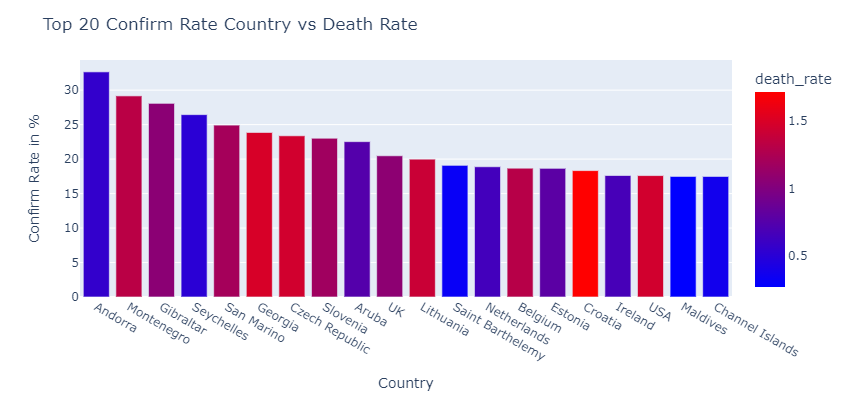

In [220]:
import plotly.express as px

fig = px.bar(summary.sort_values('confirm_rate', ascending=False).head(20), 
             x='country', y='confirm_rate',
             hover_data=['test_rate','confirm_rate','critical_rate','death_rate','percentage_fully_vaccinated','percentage_vaccinated'], 
             color='death_rate',
             color_continuous_scale=px.colors.sequential.Bluered,
             labels={'pop':'population'}, height=400)
fig.update_layout(
    title="Top 20 Confirm Rate Country vs Death Rate",
    xaxis_title="Country",
    yaxis_title="Confirm Rate in %",
    legend_title="Death Rate in %"
)
fig.show()

#### top 20 death_rate countries

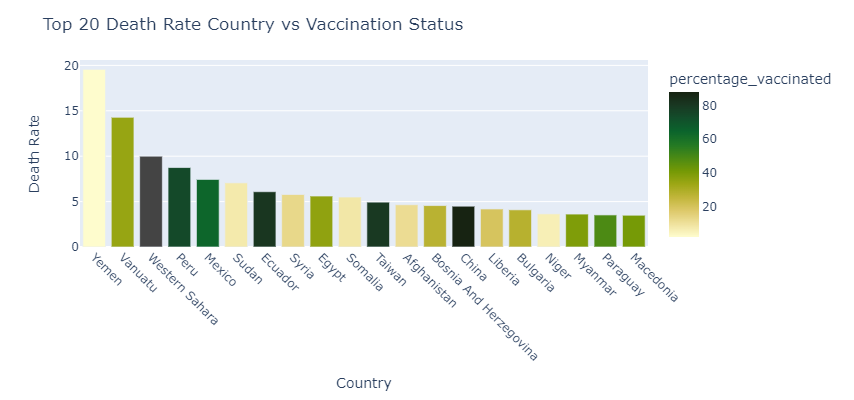

In [224]:
import plotly.express as px

fig = px.bar(summary.sort_values('death_rate', ascending=False).head(20), 
             x='country', y='death_rate',
             hover_data=['test_rate','confirm_rate','critical_rate','death_rate','percentage_fully_vaccinated','percentage_vaccinated'], 
             color='percentage_vaccinated',
             color_continuous_scale=px.colors.sequential.speed,
             labels={'pop':'population'}, height=400)
fig.update_layout(
    title="Top 20 Death Rate Country vs Vaccination Status",
    xaxis_title="Country",
    yaxis_title="Death Rate",
    legend_title="Vaccinated Percentage"
)
fig.update_xaxes(tickangle=45)
fig.show()

#### Explore possible relationships

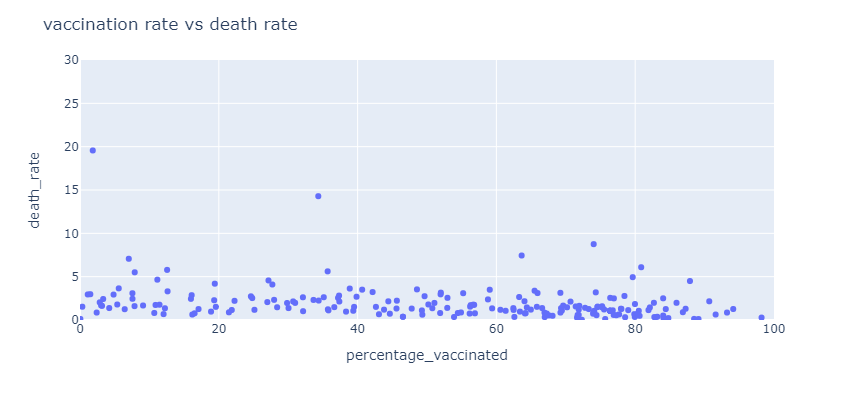

In [153]:
#no clear relationship
import plotly.express as px
fig = px.scatter(summary, x="percentage_vaccinated", y="death_rate")
fig.update_layout(
    autosize=False,
    width=400,
    height=400,
    yaxis_range=[0,30],
    xaxis_range=[0,100],
    title="vaccination rate vs death rate"
)
fig.show()

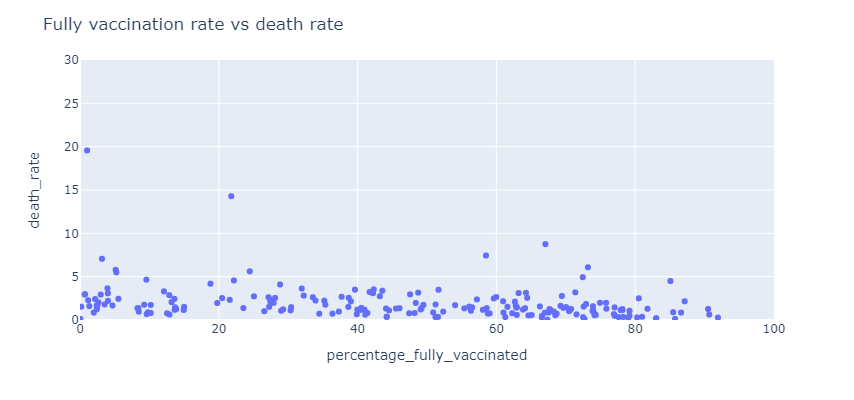

In [156]:
#slight decrease?
import plotly.express as px
fig = px.scatter(summary, x="percentage_fully_vaccinated", y="death_rate")
fig.update_layout(
    autosize=False,
    width=400,
    height=400,
    yaxis_range=[0,30],
    xaxis_range=[0,100],
    title="Fully vaccination rate vs death rate"
)
fig.show()

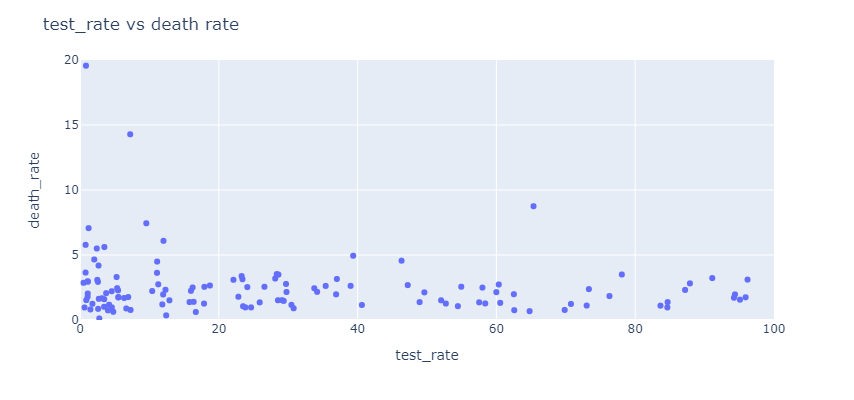

In [157]:
#no clear relationship
import plotly.express as px
fig = px.scatter(summary, x="test_rate", y="death_rate")
fig.update_layout(
    autosize=False,
    width=400,
    height=400,
    yaxis_range=[0,20],
    xaxis_range=[0,100],
    title="test rate vs death rate"
)
fig.show()

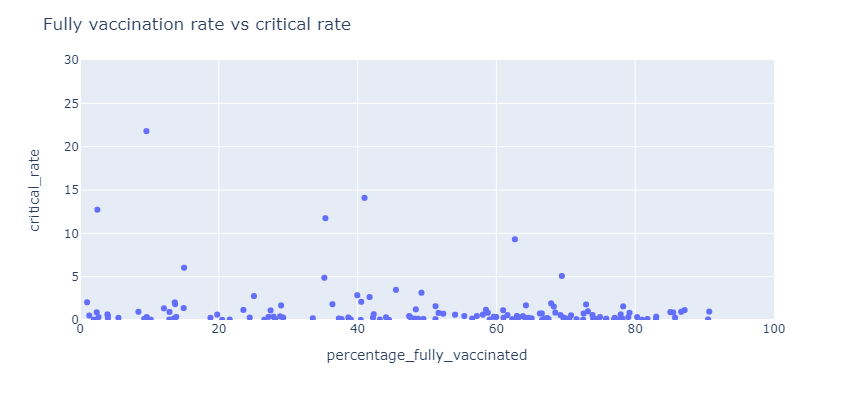

In [159]:
#no clear relationship
import plotly.express as px
fig = px.scatter(summary, x="percentage_fully_vaccinated", y="critical_rate")
fig.update_layout(
    autosize=False,
    width=400,
    height=400,
    yaxis_range=[0,30],
    xaxis_range=[0,100],
    title="Fully vaccination rate vs critical rate"
)
fig.show()

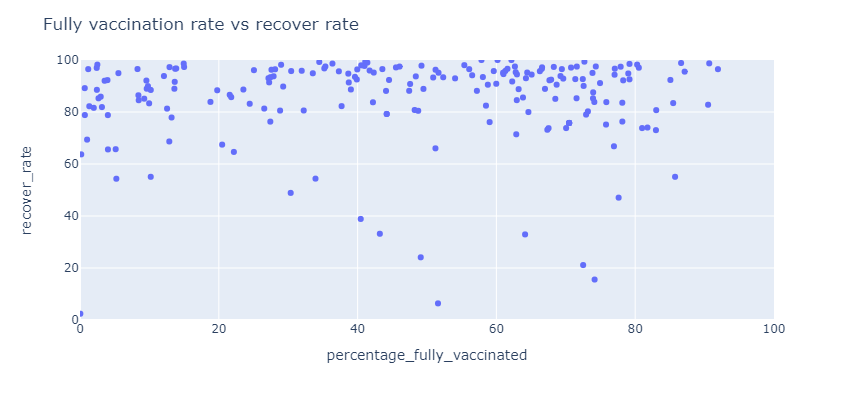

In [162]:
#no clear relationship
import plotly.express as px
fig = px.scatter(summary, x="percentage_fully_vaccinated", y="recover_rate")
fig.update_layout(
    autosize=False,
    width=400,
    height=400,
    yaxis_range=[0,100],
    xaxis_range=[0,100],
    title="Fully vaccination rate vs recover rate"
)
fig.show()

#### Countries with Active Cases

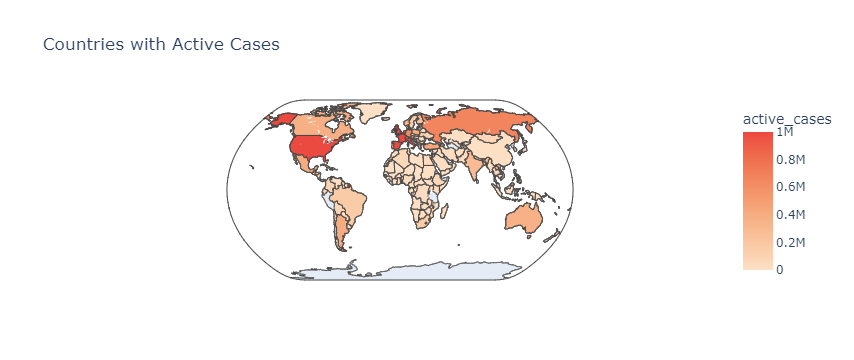

In [113]:
figure = px.choropleth(summary, locations="country", 
                    locationmode='country names', color="active_cases", 
                    hover_name="country", range_color=[1,1000000], 
                    color_continuous_scale="Peach", title ="Countries with Active Cases",
                    projection="natural earth")
fig.update_layout(
    autosize=False,
    width=600,
    height=400
)
figure.show()

#### Countries with Total Confirmed Case

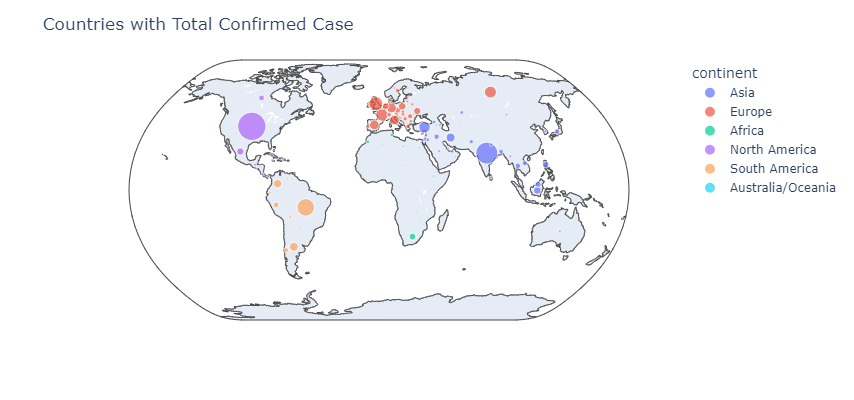

In [112]:
import plotly.express as px
fig = px.scatter_geo(summary,locations="iso_code", color="continent",size="total_confirmed",hover_name="country",
                     projection="natural earth")
fig.update_layout(
    title ="Countries with Total Confirmed Case",
    autosize=False,
    width=600,
    height=400
)
fig.show()

#### Vaccines Being Used by Countries

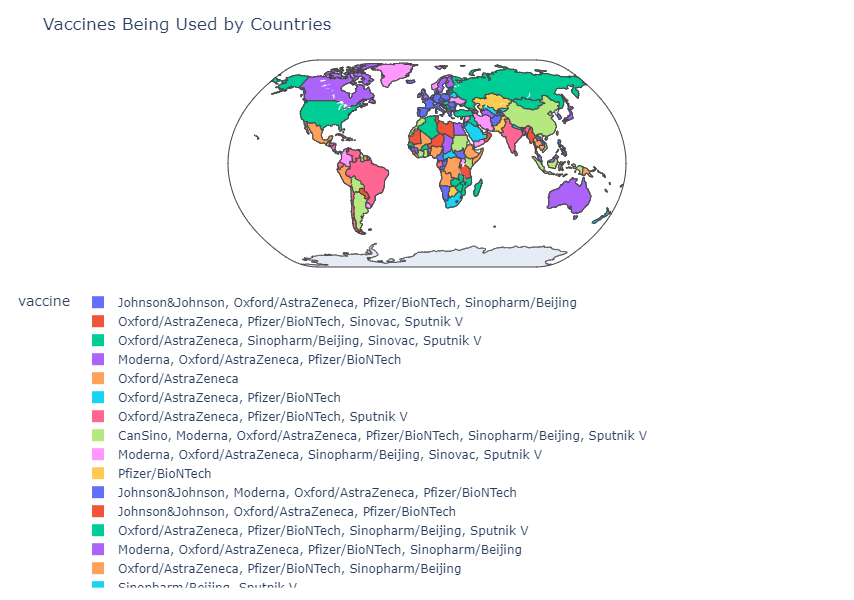

In [111]:
fig = ex.choropleth(vaccine_country_df, locations="country", 
                    locationmode='country names',
                    color="vaccine", 
                    hover_name="country", 
                   projection="natural earth")
fig.update_layout(
    title="Vaccines Being Used by Countries", 
    autosize=False,
    width=600,
    height=600,
    legend_orientation = 'h'
)
fig.show()

#### Popularity of vaccination combinations

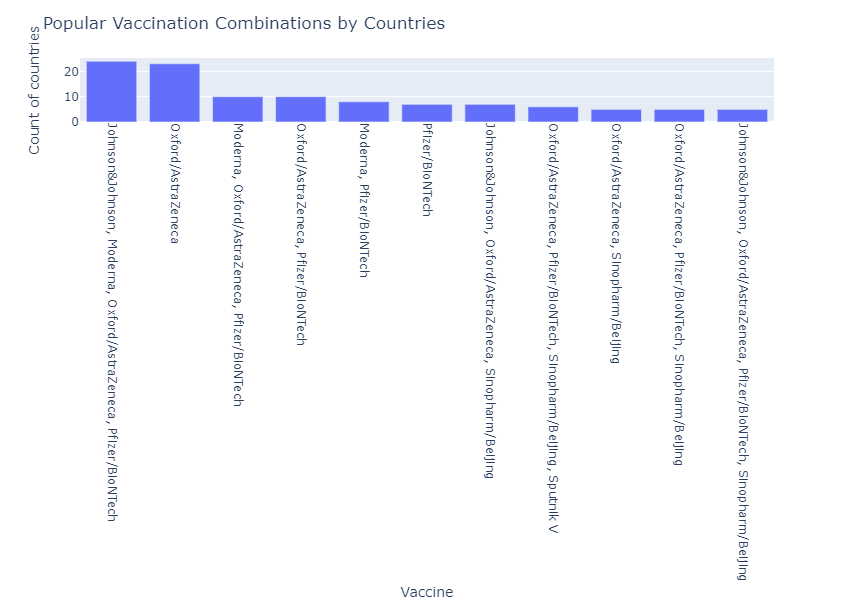

In [256]:
fig = px.bar(head_pop_vacc_df, x='vaccine', y='count')
fig.update_layout(
    title="Popular Vaccination Combinations by Countries",
    xaxis_title="Vaccine",
    yaxis_title="Count of countries",
    autosize=False,
    width=600,
    height=600
)
fig.update_xaxes(tickangle=90)
fig.show()

## (2) With Daily Data - What kind of trends and patterns has happened? - Any critical points related to Omicron?

Available data sets: 
- daily_df
- global_daily
- vacc_df
- global_dailyvacc

#### 2.1 Country distribution - geo map

In [70]:
import pandas as pd
import chart_studio.plotly as py
import plotly.offline as po
import plotly.graph_objs as pg
import matplotlib.pyplot as plt
%matplotlib inline
po.init_notebook_mode(connected = True)

In [71]:
daily_df.tail()

date   country  cumulative_total_cases  daily_new_cases  \
152730  2022-1-01  Zimbabwe                214214.0            956.0   
152731  2022-1-02  Zimbabwe                214878.0            664.0   
152732  2022-1-03  Zimbabwe                216087.0           1209.0   
152733  2022-1-04  Zimbabwe                217678.0           1591.0   
152734  2022-1-05  Zimbabwe                219057.0           1379.0   

        active_cases  cumulative_total_deaths  daily_new_deaths date_parsed  
152730       26786.0                   5017.0              13.0  2022-01-01  
152731       26585.0                   5032.0              15.0  2022-01-02  
152732       25446.0                   5047.0              15.0  2022-01-03  
152733       24620.0                   5078.0              31.0  2022-01-04  
152734       24252.0                   5092.0              14.0  2022-01-05

In [100]:
'''
import plotly.express as px
px.scatter(daily_df, x="daily_new_cases", y="daily_new_deaths", animation_frame="date_parsed", animation_group="country",
           size="cumulative_total_cases", color="country", hover_name="country",
          size_max=55, range_x=[0,1000000], range_y=[0,6000])
'''

'\nimport plotly.express as px\npx.scatter(daily_df, x="daily_new_cases", y="daily_new_deaths", animation_frame="date_parsed", animation_group="country",\n           size="cumulative_total_cases", color="country", hover_name="country",\n          size_max=55, range_x=[0,1000000], range_y=[0,6000])\n'

In [101]:
vacc_df.tail()                 

country iso_code        date  total_vaccinations  people_vaccinated  \
73004  Zimbabwe      ZWE  2022-01-21           7496882.0          4234640.0   
73005  Zimbabwe      ZWE  2022-01-22           7506786.0          4239537.0   
73006  Zimbabwe      ZWE  2022-01-23           7512903.0          4242647.0   
73007  Zimbabwe      ZWE  2022-01-24           7517985.0          4245063.0   
73008  Zimbabwe      ZWE  2022-01-25           7525574.0          4248576.0   

       people_fully_vaccinated  daily_vaccinations  \
73004                3262242.0             10405.0   
73005                3267249.0             10567.0   
73006                3270256.0             10631.0   
73007                3272922.0             10273.0   
73008                3276998.0              9579.0   

       total_vaccinations_per_hundred  people_vaccinated_per_hundred  \
73004                           49.67                          28.06   
73005                           49.74                          28.09   
73006                           49.78                          28.11   
73007                           49.81                          28.13   
73008                           49.86                          28.15   

       people_fully_vaccinated_per_hundred  daily_vaccinations_per_million  \
73004                                21.62                           689.0   
73005                                21.65                           700.0   
73006                                21.67                           704.0   
73007                                21.69                           681.0   
73008                                21.71                           635.0   

                                                vaccines         source_name  \
73004  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73005  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73006  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73007  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   
73008  Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac...  Ministry of Health   

                                          source_website date_parsed  
73004  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-21  
73005  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-22  
73006  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-23  
73007  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-24  
73008  https://www.arcgis.com/home/webmap/viewer.html...  2022-01-25

# Animations...??

#### 2.2 global

In [102]:
global_daily.head()

daily_new_cases  daily_new_deaths  active_cases  \
date                                                         
2020-1-22              0.0               0.0         554.0   
2020-1-23            259.0               8.0         771.0   
2020-1-24            457.0              16.0        1208.0   
2020-1-25            688.0              15.0        1870.0   
2020-1-26            769.0              24.0        2613.0   

           cumulative_total_cases  cumulative_total_deaths  \
date                                                         
2020-1-22                   571.0                     17.0   
2020-1-23                   830.0                     25.0   
2020-1-24                  1287.0                     41.0   
2020-1-25                  1975.0                     56.0   
2020-1-26                  2744.0                     80.0   

           total_vaccinations  people_vaccinated  people_fully_vaccinated  \
date                                                                        
2020-1-22                 NaN                NaN                      NaN   
2020-1-23                 NaN                NaN                      NaN   
2020-1-24                 NaN                NaN                      NaN   
2020-1-25                 NaN                NaN                      NaN   
2020-1-26                 NaN                NaN                      NaN   

           daily_vaccinations  
date                           
2020-1-22                 NaN  
2020-1-23                 NaN  
2020-1-24                 NaN  
2020-1-25                 NaN  
2020-1-26                 NaN

In [103]:
global_dailyvacc.head()

total_vaccinations  people_vaccinated  people_fully_vaccinated  \
date                                                                         
2020-12-01                 1.0                1.0                      0.0   
2020-12-02                 0.0                0.0                      0.0   
2020-12-03                 0.0                0.0                      0.0   
2020-12-04                 1.0                1.0                      0.0   
2020-12-05                 0.0                0.0                      0.0   

            daily_vaccinations  
date                            
2020-12-01                 0.0  
2020-12-02                 0.0  
2020-12-03                 0.0  
2020-12-04                 0.0  
2020-12-05                 0.0

#### 2.2.1 global - daily

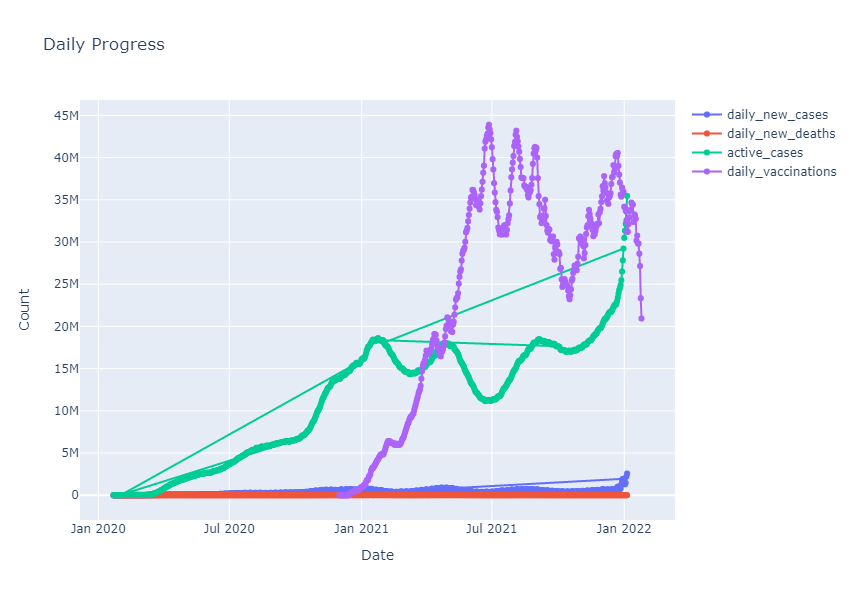

In [225]:
line_plots = []
variable_list=["daily_new_cases","daily_new_deaths","active_cases","daily_vaccinations"]
for variable in variable_list:
    line_plots.append(
        go.Scatter(
            name=variable,
            x = global_daily.index,
            mode = "lines+markers",
            y=global_daily[variable],
        )
    )
fig = go.Figure(line_plots)
fig.update_layout(
    title ="Daily Progress",
    xaxis_title="Date",
    yaxis_title="Count",
    hovermode='x',
    legend_orientation = 'v',
    autosize=False,
    width=800,
    height=600
)
fig.show()

#### 2.2.2 global - total

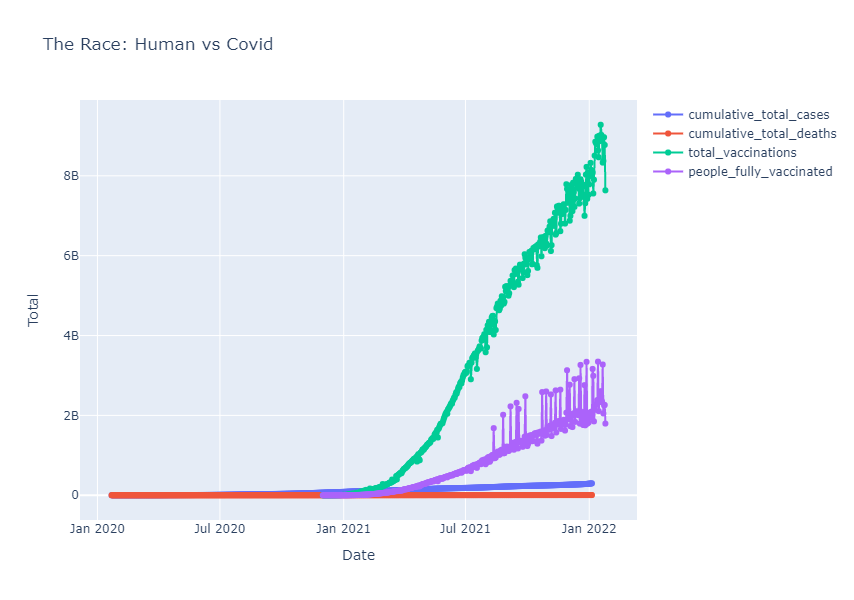

In [105]:
line_plots = []
variable_list=["cumulative_total_cases","cumulative_total_deaths","total_vaccinations","people_fully_vaccinated"]
for variable in variable_list:
    line_plots.append(
        go.Scatter(
            name=variable,
            x = global_daily.index,
            mode = "lines+markers",
            y=global_daily[variable],
        )
    )
fig = go.Figure(line_plots)
fig.update_layout(
    title ="The Race: Human vs Covid",
    xaxis_title="Date",
    yaxis_title="Total",
    hovermode='x',
    legend_orientation = 'v',
    autosize=False,
    width=800,
    height=600
)
fig.show()

## (3) With Vaccination by manufacture Data 

Available data sets:
- vacc_manu
- global_vacc_manu

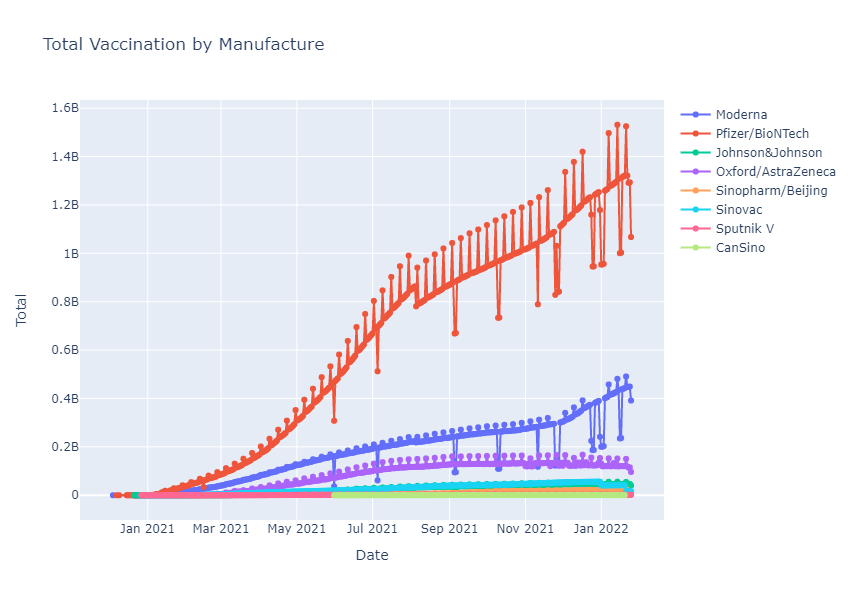

In [106]:
line_plots = []
vaccines = global_vacc_manu.vaccine.unique().tolist()
for v in vaccines:
    vacc_data = global_vacc_manu[global_vacc_manu.vaccine == v]
    line_plots.append(
        go.Scatter(
            name = v,
            x = vacc_data.date,
            mode = "lines+markers",
            y=vacc_data['total_vaccinations'],
        )
    )
fig = go.Figure(line_plots)
fig.update_layout(
    title ="Total Vaccination by Manufacture",
    xaxis_title="Date",
    yaxis_title="Total",
    hovermode='x',
    legend_orientation = 'v',
    autosize=False,
    width=800,
    height=600
)
fig.show()